In [1]:
!mkdir results

하위 디렉터리 또는 파일 results이(가) 이미 있습니다.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchsummary import summary
import numpy as np
import argparse
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.optim as optim

<h2> 1. Data Processing

<h3> Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

partition = {'train' : trainset, 'val' : valset, 'test' : testset}

Files already downloaded and verified
Files already downloaded and verified


<h3> Pharameters Setting

In [ ]:
# =========== Seed Initialization =========== #
seed = 111
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# =========== Model Capacity =========== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'


# =========== Regularization =========== #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# =========== Optimizer & Training =========== #
args.optim = 'RMSprop'
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# =========== Experiment Variables =========== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]

<h2> 2. Model Architecture

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
model = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True)
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.1)
)


<h2> 3. Train & Evaluation Functions

In [5]:
def train (model, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], batch_size=args.train_batch_size, shuffle=True, num_workers=2)
    
    model.train()
    optimizer.zero_grad()
    
    correct = 0
    total = 0
    train_loss = 0.0
    for n, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return model, train_loss, train_acc

In [6]:
def validate(model, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    
    model.eval()
    
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(args.device)
            labels = labels.to(args.device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    
    return val_loss, val_acc

In [7]:
def test(model, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    
    model.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(args.device)
            labels = labels.to(args.device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_acc = 100 * correct / total
    
    return test_acc

In [8]:
def experiment(partition, args):
    
    model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    model.to(args.device)
    
    # =========== Parameters Optimizer =========== #
    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer')
        
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    # =========== Train & validation =========== #
    for epoch in range(args.epoch):
        st = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(model, partition, criterion, args)
        et = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, et-st))
        
    test_acc = test(model, partition, args)
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

<h2> 4. Manage Experiment Result

<h3> Save & Load

In [9]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']
    
    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)
        
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df, list_result

<h3> Visualization Function

In [10]:
import seaborn as sns

def plot_acc(var1, var2, df):
    
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axies.facecolor" : ".9"})
    
    sns.barplot(x=var1, y="train_acc", hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y="val_acc", hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y="test_acc", hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title("train Accuracy")
    ax[1].set_title("Validation Accuracy")
    ax[2].set_title("Test Accuracy")
    
def plot_loss_variation(var1, var2, df, **kwargs):
    
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []
    
    for v1 in list_v1:
        for v2 in list_v2:
            row = df.loc[df[var1]==v1]
            row = row.loc[df[var2]==v2]
            
            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]
            
            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:v1, var2:v2})
                
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:v1, var2:v2})
                
    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle("Train loss & Val loss")
    plt.subplots_adjust(top=0.89)

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
        

    
def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')
    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)    

<h3> Run Experiment

In [ ]:
for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
        
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

<h3> Plot Result

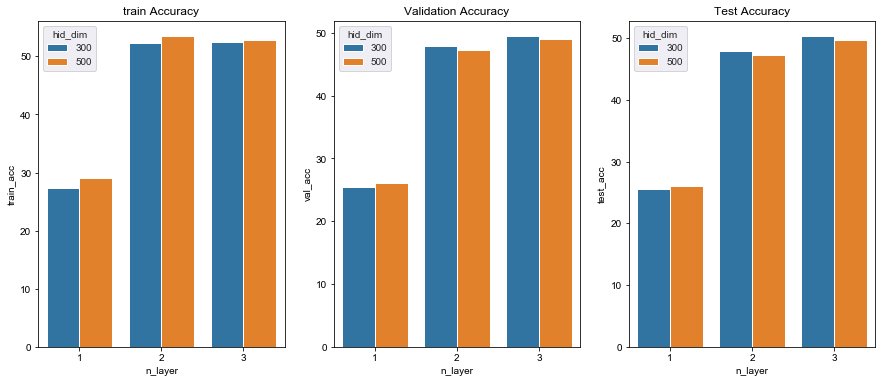

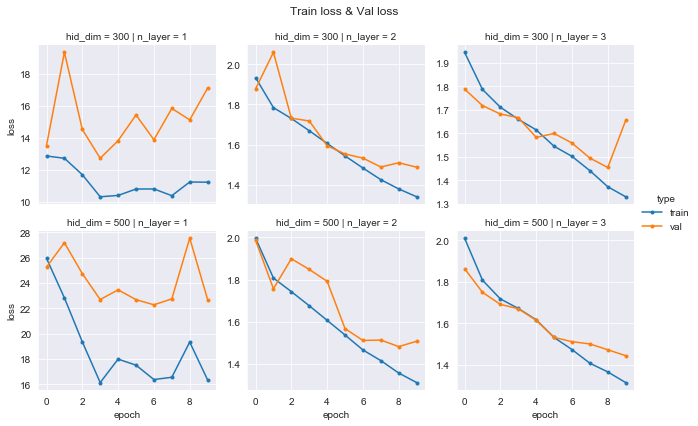

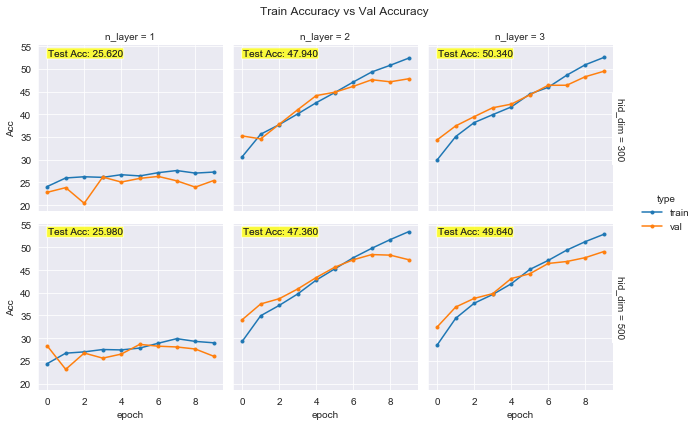

In [11]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) # Sharey True y 축 스케일 같아짐
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

In [ ]:
df